In [358]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

data49224


In [359]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [360]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

mkdir: cannot create directory ‘/home/aistudio/external-libraries’: File exists
Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 122kB 17.9MB/s eta 0:00:01


In [361]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

In [362]:
import numpy as np
import json
import matplotlib.pyplot as plt
import paddle.nn.functional as F

In [363]:
def load_data():
    # 从文件导入数据
    datafile = './data/data49224/housing.data'
    data = np.fromfile(datafile, sep=' ')

    # 每条数据包括14项，其中前面13项是影响因素，第14项是相应的房屋价格中位数
    feature_names = [ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', \
                      'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV' ]
    feature_num = len(feature_names)

    # 将原始数据进行Reshape，变成[N, 14]这样的形状
    data = data.reshape([data.shape[0] // feature_num, feature_num])

    # 将原数据集拆分成训练集和测试集
    # 这里使用80%的数据做训练，20%的数据做测试
    # 测试集和训练集必须是没有交集的
    ratio = 0.8
    offset = int(data.shape[0] * ratio)
    training_data = data[:offset]

    # 计算训练集的最大值，最小值，平均值
    maximums, minimums, avgs = training_data.max(axis=0), training_data.min(axis=0), \
                                 training_data.sum(axis=0) / training_data.shape[0]

    global max_values
    global min_values
    global avg_values
    max_values=maximums
    min_values=minimums
    avg_values=avgs

    # 对数据进行归一化处理
    for i in range(feature_num):
        #print(maximums[i], minimums[i], avgs[i])
        data[:, i] = (data[:, i] - minimums[i]) / (maximums[i] - minimums[i])

    # 训练集和测试集的划分比例
    training_data = data[:offset]
    test_data = data[offset:]
    return training_data, test_data

In [364]:
# 定义隐藏层使用的激活函数
def Sigmoid(x):
    return 1/(1+np.exp(-x))

In [365]:
# 创建一个两层神经网络的类

class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        np.random.seed(0)
        #初始化参数
        self.w1 = np.random.randn(num_of_weights, 128)
        self.b1 = 0.
        self.w2=np.random.randn(128,1)
        self.b2=0.
        
    def forward(self, x):
        #正向传播
        z1 = np.dot(x, self.w1) + self.b1
        o1=Sigmoid(z1)
        o2= np.dot(o1,self.w2)+self.b2
        return z1,o1,o2
    
    #计算损失
    def loss(self, z, y):
        error = z - y
        num_samples = error.shape[0]
        cost = error * error
        cost = np.sum(cost) / num_samples
        return cost
    
    def gradient(self, x, y, z1,o1,o2):

        #此处略复杂，经过手工计算梯度反向传播公式，然后分别计算相应的梯度
        N = o1.shape[0]
        gradient_w2 = 1. / N * np.sum((o2-y) * o1, axis=0)
        gradient_w2 = gradient_w2[:, np.newaxis]
        gradient_b2 = 1. / N * np.sum(o2-y)

        M=x.shape[0]
        gradient_w1=1. /M*np.sum(np.dot(self.w2.T,np.dot(o1.T,(o2-y)))*np.dot(x.T,(1-o1)),axis=0)
        gradient_w1 = gradient_w1[:, np.newaxis]
        gradient_b1=1. /M*np.sum(np.dot(self.w2.T,np.dot(o1.T,(o2-y)))*(1-o1),axis=0)

        return gradient_w1, gradient_b1,gradient_w2, gradient_b2
    
    #根据计算出的梯度分别对两层的参数进行更新
    def update(self, gradient_w1, gradient_b1, gradient_w2, gradient_b2, eta = 0.01):
        self.w2 = self.w2 - eta * gradient_w2
        self.b2 = self.b2 - eta * gradient_b2
        self.w1 = self.w1 - eta * gradient_w1.T
        self.b1 = self.b1 - eta * gradient_b1
            
    # 训练过程
    def train(self, training_data, num_epochs, batch_size=10, eta=0.01):
        n = len(training_data)
        losses = []
        for epoch_id in range(num_epochs):
            # 在每轮迭代开始之前，将训练数据的顺序随机打乱
            # 然后再按每次取batch_size条数据的方式取出
            np.random.shuffle(training_data)
            # 将训练数据进行拆分，每个mini_batch包含batch_size条的数据
            mini_batches = [training_data[k:k+batch_size] for k in range(0, n, batch_size)]
            for iter_id, mini_batch in enumerate(mini_batches):
                #print(self.w.shape)
                #print(self.b)
                x = mini_batch[:, :-1]
                y = mini_batch[:, -1:]
                z1,o1,o2 = self.forward(x)
                loss = self.loss(o2, y)
                gradient_w1, gradient_b1, gradient_w2, gradient_b2= self.gradient(x, y, z1,o1,o2)
                self.update(gradient_w1, gradient_b1, gradient_w2, gradient_b2, eta)
                losses.append(loss)
                print('Epoch {:3d} / iter {:3d}, loss = {:.4f}'.
                                 format(epoch_id, iter_id, loss))
        
        return losses


Epoch   0 / iter   0, loss = 86.1997
Epoch   0 / iter   1, loss = 0.0605
Epoch   0 / iter   2, loss = 0.0694
Epoch   0 / iter   3, loss = 0.0720
Epoch   0 / iter   4, loss = 0.1004
Epoch   1 / iter   0, loss = 0.0493
Epoch   1 / iter   1, loss = 0.0869
Epoch   1 / iter   2, loss = 0.0658
Epoch   1 / iter   3, loss = 0.0890
Epoch   1 / iter   4, loss = 0.0466
Epoch   2 / iter   0, loss = 0.0709
Epoch   2 / iter   1, loss = 0.0730
Epoch   2 / iter   2, loss = 0.0644
Epoch   2 / iter   3, loss = 0.0824
Epoch   2 / iter   4, loss = 0.0076
Epoch   3 / iter   0, loss = 0.0828
Epoch   3 / iter   1, loss = 0.0593
Epoch   3 / iter   2, loss = 0.0642
Epoch   3 / iter   3, loss = 0.0819
Epoch   3 / iter   4, loss = 0.0635
Epoch   4 / iter   0, loss = 0.0674
Epoch   4 / iter   1, loss = 0.0911
Epoch   4 / iter   2, loss = 0.0599
Epoch   4 / iter   3, loss = 0.0731
Epoch   4 / iter   4, loss = 0.0263
Epoch   5 / iter   0, loss = 0.0836
Epoch   5 / iter   1, loss = 0.0804
Epoch   5 / iter   2, loss 

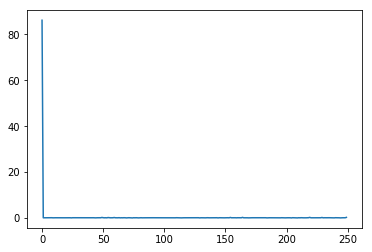

In [366]:
train_data, test_data = load_data()

# 创建网络
net = Network(13)
# 启动训练
losses = net.train(train_data, num_epochs=50, batch_size=100, eta=0.001)

# 画出损失函数的变化趋势
plot_x = np.arange(len(losses))
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.show()

In [367]:
def load_one_example():
    # 从上边已加载的测试集中，随机选择一条作为测试数据
    idx = np.random.randint(0, test_data.shape[0])
    one_data, label = test_data[idx, :-1], test_data[idx, -1]
    # 修改该条数据shape为[1,13]
    one_data =  one_data.reshape([1,-1])

    return one_data, label

In [369]:
one_data, label = load_one_example()
_, _, predict=net.forward(one_data)

# 对结果做反归一化处理
predict = predict * (max_values[-1] - min_values[-1]) + avg_values[-1]
# 对label数据做反归一化处理
label = label * (max_values[-1] - min_values[-1]) + avg_values[-1]

print("Inference result is {}, the corresponding label is {}".format(predict, label))

Inference result is [[31.73786137]], the corresponding label is 32.77574257425745
